In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from TOV_Solver import WaveNetTOV, evaluate_model
import matplotlib.pyplot as plt
import joblib
from TOV_Solver import tov_load_and_preprocess
from preprocessing import _resample_group


Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Train Loss: 0.000186 | Val Loss: 0.000187 | Val R²: 0.997314 | LR: 1.000000e-05
ckpt = torch.load("models/tov_solver.pt", map_location="cpu")

# 3️⃣ If it’s a dict:
model = WaveNetTOV()
model.load_state_dict(ckpt)
model.eval()

WaveNetTOV(
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (input_conv): CausalConv1d()
  (hidden_layers): ModuleList(
    (0-7): 8 x CausalConv1d()
  )
  (output_conv): CausalConv1d()
)

Input Data

In [4]:
df = pd.read_csv("data/sample_mr.csv")

# pick one ID/model pair
group = df[(df["ID"] == df["ID"].iloc[0]) & (df["model"] == df["model"].iloc[0])]

out = _resample_group(group, column="M", Np=32)
print(out)

         ID  model          R         M
0   17289.0  RMFNL  15.038479  0.210319
1   17289.0  RMFNL  14.116756  0.243343
2   17289.0  RMFNL  12.881331  0.327709
3   17289.0  RMFNL  12.607693  0.379473
4   17289.0  RMFNL  12.250477  0.502310
5   17289.0  RMFNL  12.160598  0.572910
6   17289.0  RMFNL  12.176042  0.730232
7   17289.0  RMFNL  12.173860  0.815547
8   17289.0  RMFNL  12.232957  0.995043
9   17289.0  RMFNL  12.251343  1.087165
10  17289.0  RMFNL  12.293681  1.270690
11  17289.0  RMFNL  12.294750  1.359928
12  17289.0  RMFNL  12.301751  1.446140
13  17289.0  RMFNL  12.251334  1.606111
14  17289.0  RMFNL  12.213419  1.678549
15  17289.0  RMFNL  12.120307  1.806232
16  17289.0  RMFNL  12.055404  1.861118
17  17289.0  RMFNL  11.907023  1.953113
18  17289.0  RMFNL  11.825703  1.990597
19  17289.0  RMFNL  11.652906  2.049994
20  17289.0  RMFNL  11.562455  2.072608
21  17289.0  RMFNL  11.476525  2.090991
22  17289.0  RMFNL  11.288833  2.116533
23  17289.0  RMFNL  11.194692  2.124392


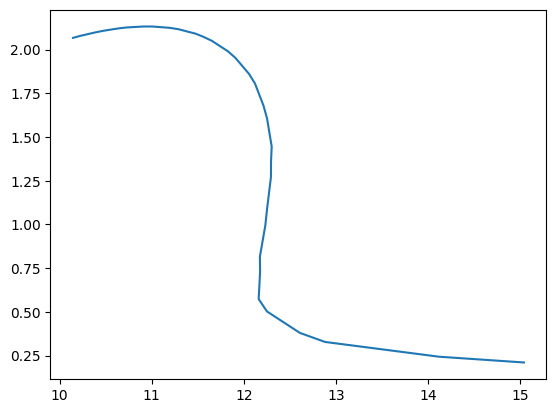

In [5]:
R = out["R"].to_numpy()
M = out["M"].to_numpy()

plt.plot(R, M)
plt.show()

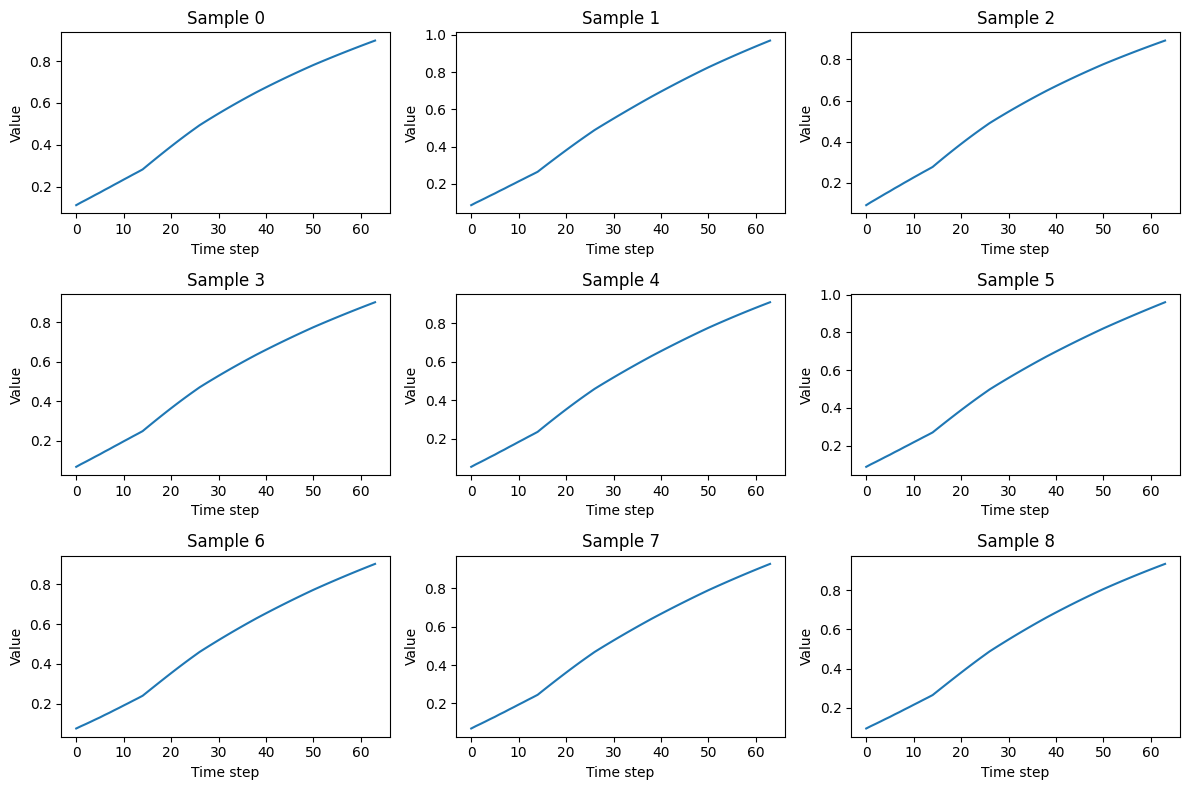

In [6]:
X_scaled = np.load("data/X_scaled.npy")
X_scaled.shape

# Plot first few samples
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(9):
    axes[i].plot(X_scaled[i, :, 1])  # Extract the feature dimension
    axes[i].set_title(f'Sample {i}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Value')
    
plt.tight_layout()

In [7]:
X_scaled[:,:, 1].max()

np.float32(1.0)

In [8]:
X_scaled[:,:, 1]

array([[0.11306152, 0.12574866, 0.13741998, ..., 0.88051724, 0.8890066 ,
        0.8974102 ],
       [0.08659428, 0.09988223, 0.11206002, ..., 0.94771475, 0.9581525 ,
        0.96848077],
       [0.09135739, 0.10594977, 0.11921406, ..., 0.8748426 , 0.8831866 ,
        0.89144135],
       ...,
       [0.08368195, 0.0955226 , 0.10647377, ..., 0.9296823 , 0.94031566,
        0.95085436],
       [0.0566671 , 0.07030081, 0.08276831, ..., 0.93032396, 0.9409976 ,
        0.9515814 ],
       [0.08677316, 0.09858441, 0.10951041, ..., 0.9290197 , 0.9392752 ,
        0.94942415]], shape=(20756, 64), dtype=float32)

In [9]:
X_scaled[:,:, 1].min()

np.float32(0.017266154)

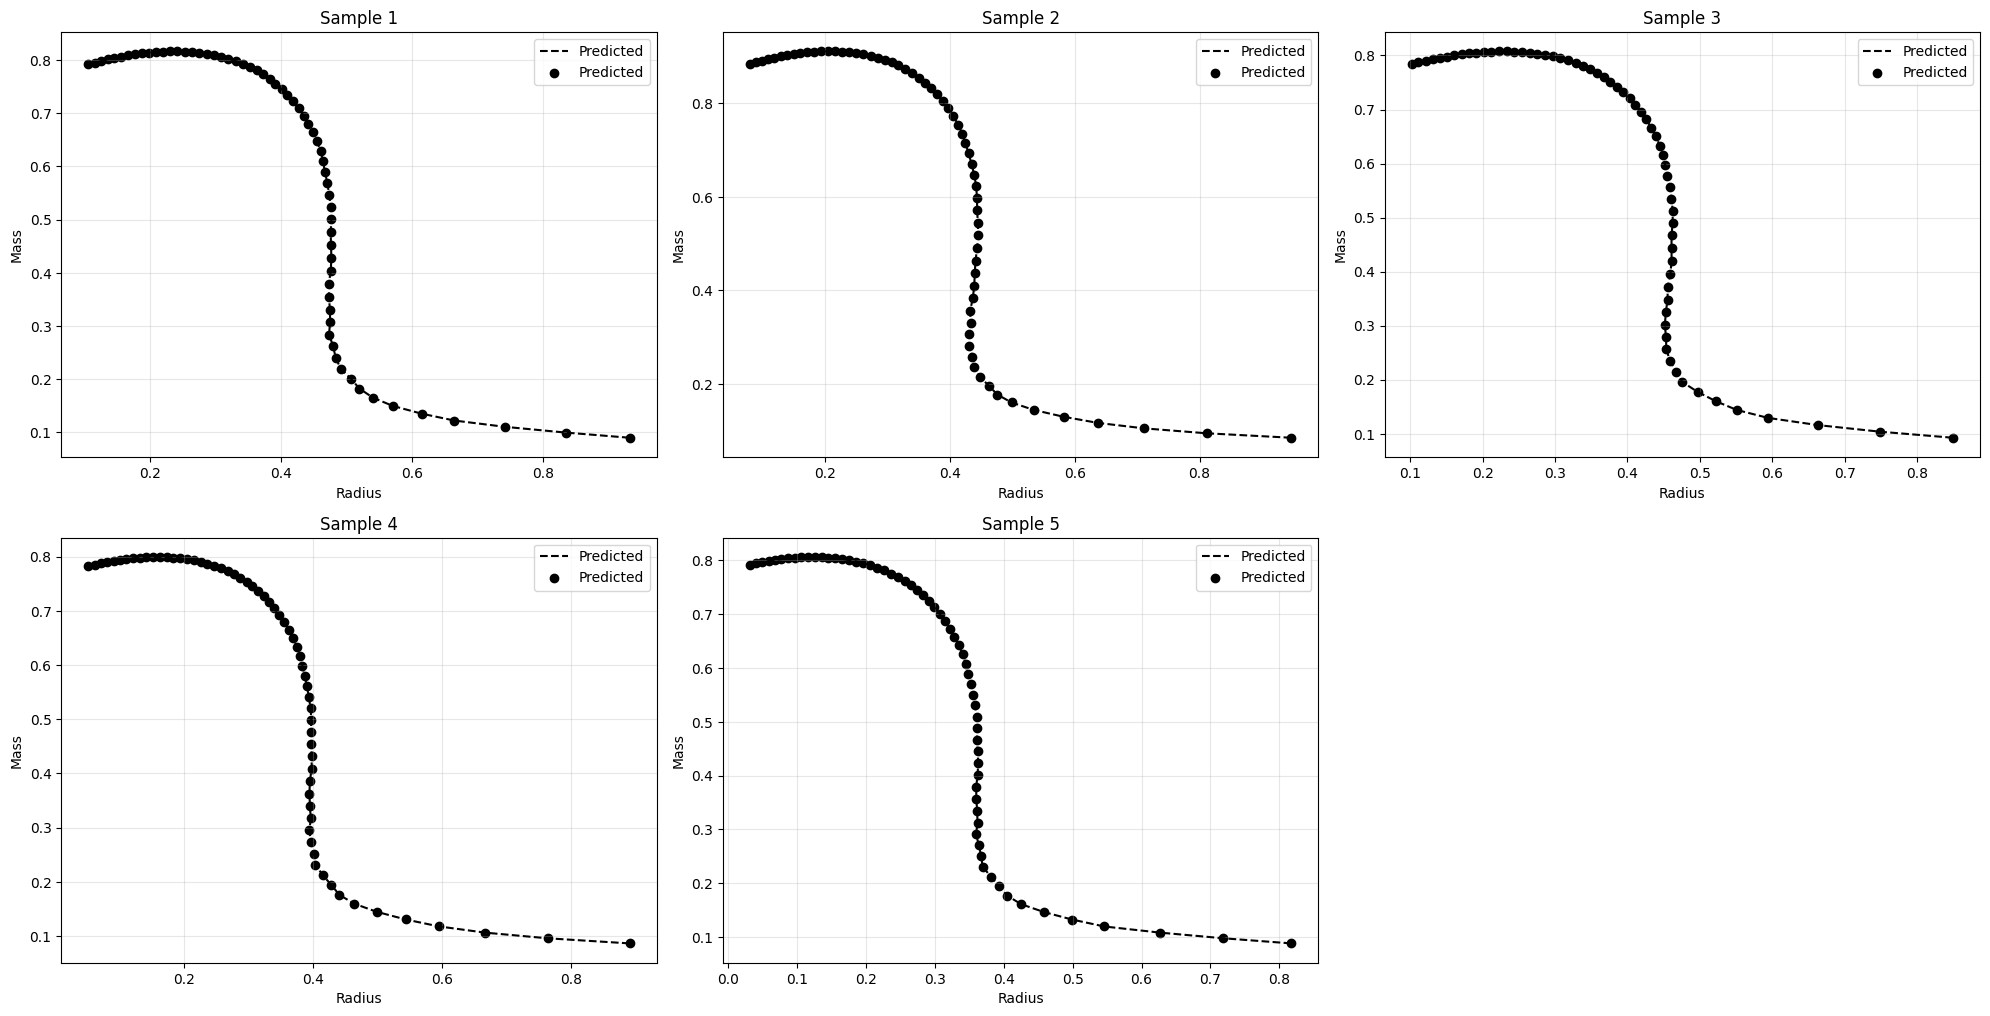

In [10]:
Y_scaled = np.load("data/Y_scaled.npy")

mass_pred_unscaled = Y_scaled[:, :, 0] 
radius_pred_unscaled = Y_scaled[:, :, 1] 

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(5):
    ax = axes[sample_idx]

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='black', label='Predicted')
    ax.scatter(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx], color='black', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(5, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Results

In [11]:
metrics, preds = evaluate_model(model, np.load("data/X_test.npy"), np.load("data/y_test.npy"))
metrics

# calculate the error on Mass and the radius separately

{'MSE': 0.00022964425443205982, 'R2': 0.996592104434967}

In [12]:
np.load("data/y_test.npy").shape

(831, 64, 2)

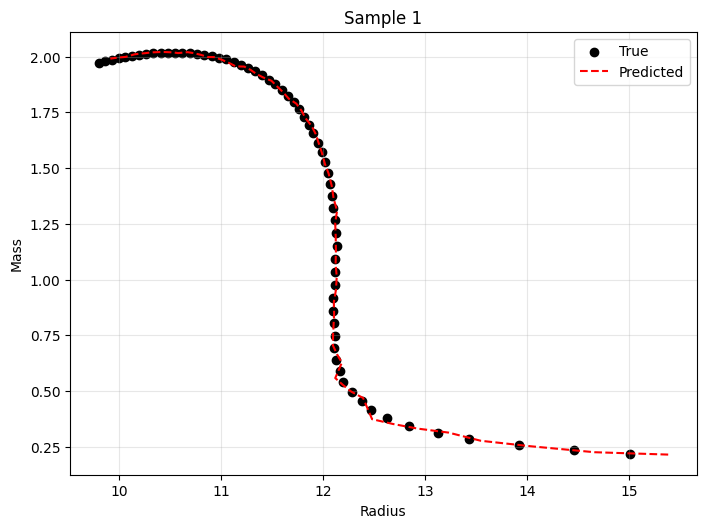

In [18]:
M_MAX = np.load("scalers/M_MAX.npy")
R_MAX = 16.0
R_MIN = np.load("scalers/R_MIN.npy")

y_test = np.load("data/y_test.npy")
mass_pred_unscaled = preds[:, :, 0] * M_MAX
radius_pred_unscaled = preds[:, :, 1] * (R_MAX - R_MIN) + R_MIN
# Inverse-transform true values
mass_true_unscaled = y_test[:, :, 0] * M_MAX
radius_true_unscaled = y_test[:, :, 1] * (R_MAX - R_MIN) + R_MIN

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()
sample_idx = 0
ax = axes[sample_idx]

# True M-R relation (black)
ax.scatter(radius_true_unscaled[sample_idx], mass_true_unscaled[sample_idx],
            color='black', label='True')

# Predicted M-R relation (red dashed line)
ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
        "--", color='red', label='Predicted')

ax.set_title(f'Sample {sample_idx + 1}')
ax.set_xlabel('Radius')
ax.set_ylabel('Mass')
ax.legend()
ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()